This notebook is just meant to test the codes before I compile them as .py files.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.io.ascii as astropy_ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

# 1. Fetch coordinates (ra, dec) from raw data

In [ ]:
# 6dFGS
df = pd.read_csv('data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)

# ra is still in hour -> need to convert to degrees
df_test = df[['ra', 'dec']]

In [ ]:
Table.from_pandas(df_test).write('6dfgs_coord.ascii', format='ipac', overwrite=True)

In [ ]:
# LAMOST
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df = pd.DataFrame(hdul[1].data)

df[['ra', 'dec']].describe()

In [ ]:
# # sdss
# df = pd.read_csv('data/raw/sdss/SDSS_spectro_mrafifrbbn.csv')

# df[['ra', 'dec']].describe()

# 2. Merge the spectroscopy and photometry

In [ ]:
# Compare the original raw data to 2MASS (check if the order is the same)
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_lamost_spectro = pd.DataFrame(hdul[1].data)
    
df_lamost_tmass = pd.read_csv('data/raw/2mass/lamost_tmass.csv', low_memory=False)

df = pd.merge(df_lamost_spectro[['ra', 'dec']], df_lamost_tmass[['ra_01', 'dec_01']], left_index=True, right_index=True)

df['delta_ra'] = df['ra_01']-df['ra']
df['delta_dec'] = df['dec_01']-df['dec']


df[['delta_ra', 'delta_dec']].describe()

In [ ]:
# Compare the original raw data to 2MASS
df_6df_spectro = pd.read_csv('data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)
df_6df_spectro['ra'] = df_6df_spectro['ra']*15

df_6df_tmass = pd.read_csv('data/raw/2mass/6dfgs_tmass.csv', low_memory=False)

df = pd.merge(df_6df_spectro[['ra', 'dec']], df_6df_tmass[['ra_01', 'dec_01']], left_index=True, right_index=True)

df['delta_ra'] = df['ra_01']-df['ra']
df['delta_dec'] = df['dec_01']-df['dec']

df[['delta_ra', 'delta_dec']].describe()

# Coba2 cross-matching

In [ ]:
# LAMOST
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_lamost = Table(hdul[1].data).to_pandas()

df_sdss = pd.read_csv('data/raw/sdss/SDSS_spectro_mrafifrbbn.csv')

In [ ]:
sdss_coords = SkyCoord(ra=df_sdss['ra'].to_numpy()*u.deg, dec=df_sdss['dec'].to_numpy()*u.deg)
lamost_coords = SkyCoord(ra=df_lamost['ra'].to_numpy()*u.deg, dec=df_lamost['dec'].to_numpy()*u.deg)

In [ ]:
idx, sep2d, _ = lamost_coords.match_to_catalog_sky(sdss_coords)
is_counterpart = sep2d < 1.*u.arcsec

df_lamost['sdss_idx'] = idx
df_lamost['sdss_counterpart'] = is_counterpart

df_lamost = df_lamost[df_lamost['sdss_counterpart']==True]

In [ ]:
df_lamost_sdss = df_lamost.merge(df_sdss, left_on='sdss_idx', right_index=True)

In [ ]:
df_lamost_sdss[['ra_x', 'dec_x', 'ra_y', 'dec_y', 'veldisp_x', 'sigmaStars']]

## Main code for merging

### 6dFGS: Combine Vizier data (what I used throughout my thesis)

In [ ]:
# FP data
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_fp = Table(hdul[1].data).to_pandas()
    
df_fp.head()

In [ ]:
# veldisp data
with fits.open('data/raw/6dfgs/sdfgs_veldisp_vizier.fits') as hdul:
    df_veldisp = Table(hdul[1].data).to_pandas()

veldisp_columns = ['_6dFGS', 'MJD', 'z', 'S_N', 'R', 'Vd', 'e_Vd', '_RA', '_DE']
df_veldisp = df_veldisp[veldisp_columns]

df_veldisp.head()

In [ ]:
df_6dfgs = df_fp.merge(df_veldisp, on='_6dFGS', how='inner')

df_6dfgs

In [ ]:
df_6df_campbell = pd.read_csv('data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)[['6dFGSid', 'ra', 'dec']]
df_6df_campbell['ra'] = df_6df_campbell['ra']

In [ ]:
df_compare = df_6dfgs.merge(df_6df_campbell, left_on='_6dFGS', right_on='6dFGSid')
df_compare['DELTA_RA'] = (df_compare['RAJ2000']-df_compare['ra'])*15*3600
df_compare['DELTA_DE'] = (df_compare['DEJ2000']-df_compare['dec'])*3600
df_compare[['RAJ2000', 'DEJ2000', 'ra', 'dec', 'DELTA_RA', 'DELTA_DE']]

In [ ]:
# Selidiki perbedaan ra_01 dec_01 (input) dan ra dan dec (dari 2MASS)
df = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')

coords_1 = SkyCoord(ra=df['ra_01'].to_numpy()*u.deg, dec=df['dec_01'].to_numpy()*u.deg)
coords_2 = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_1.match_to_catalog_sky(coords_2)

plt.hist(sep2d.arcsec, bins=100)
plt.show()

In [ ]:
# Selidiki perbedaan ra_01 dec_01 dan sup_ra dan sup_dec
df = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')

coords_1 = SkyCoord(ra=df['ra_01'].to_numpy()*u.deg, dec=df['dec_01'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=df['sup_ra'].to_numpy()*u.deg, dec=df['sup_dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_1.match_to_catalog_sky(coords_sup)

plt.hist(sep2d.arcsec, bins=100)
plt.show()

In [ ]:
max(sep2d.arcsec)

In [ ]:
len(df)

In [ ]:
# Selidiki perbedaan ra dec dan sup_ra dan sup_dec
df = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')

coords_1 = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=df['sup_ra'].to_numpy()*u.deg, dec=df['sup_dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_1.match_to_catalog_sky(coords_sup)

plt.hist(sep2d.arcsec, bins=100)
plt.show()

##### Eksperimen mau pake ra dec atau sup_ra dan sup_dec (dan berapa threshold yang optimal)

In [ ]:
# Ambil data vizier (11102 galaksi)
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_6df = Table(hdul[1].data).to_pandas()[['_2MASX', 'RAJ2000', 'DEJ2000']]
df_6df['RAJ2000'] *= 15
df_6df['_2MASX'] = '2MASX' + df_6df['_2MASX']
    
# Ambil data 2MASS (11117 galaksi)
df_2mass = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')[['designation', 'ra_01', 'dec_01', 'ra', 'dec', 'sup_ra', 'sup_dec']]
df_2mass['_2MASX'] = '2MASXJ' + df_2mass['designation']

# Find the extra 15 galaxies
dfe = pd.merge(df_2mass, df_6df, how='left', on='_2MASX', indicator=True).query('_merge=="left_only"')

# Store the coordinates
coords_ori = SkyCoord(ra=dfe['ra_01'].to_numpy()*u.deg, dec=dfe['dec_01'].to_numpy()*u.deg)
coords_radec = SkyCoord(ra=dfe['ra'].to_numpy()*u.deg, dec=dfe['dec'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=dfe['sup_ra'].to_numpy()*u.deg, dec=dfe['sup_dec'].to_numpy()*u.deg)

f, (ax1, ax2) = plt.subplots(nrows=2)

# Find the separation between ra_01 dec_01 (original data) with ra dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_radec)
print(f'Min sep2d with ra and dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with ra and dec: {max(sep2d.arcsec)}')
ax1.hist(sep2d.arcsec)
ax1.set_title('Sep2d for the extra 15 galaxies with ra and dec')

print('\n')

# Find the separation between ra_01 dec_01 (original data) with sup_ra and sup_dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_sup)
print(f'Min sep2d with sup_ra and sup_dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with sup_ra and sup_dec: {max(sep2d.arcsec)}')
ax2.hist(sep2d.arcsec)
ax2.set_title('Sep2d for the extra 15 galaxies with sup_ra and sup_dec')

f.tight_layout()
plt.show()

In [ ]:
# Find the common 11102 galaxies
dfe = pd.merge(df_2mass, df_6df, how='left', on='_2MASX', indicator=True).query('_merge=="both"')

# Store the coordinates
coords_ori = SkyCoord(ra=dfe['ra_01'].to_numpy()*u.deg, dec=dfe['dec_01'].to_numpy()*u.deg)
coords_radec = SkyCoord(ra=dfe['ra'].to_numpy()*u.deg, dec=dfe['dec'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=dfe['sup_ra'].to_numpy()*u.deg, dec=dfe['sup_dec'].to_numpy()*u.deg)

f, (ax1, ax2) = plt.subplots(nrows=2)

# Find the separation between ra_01 dec_01 (original data) with ra dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_radec)
print(f'Min sep2d with ra and dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with ra and dec: {max(sep2d.arcsec)}')
ax1.hist(sep2d.arcsec, bins=100)
ax1.set_title('Sep2d for the extra 15 galaxies with ra and dec')

print('\n')

# Find the separation between ra_01 dec_01 (original data) with sup_ra and sup_dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_sup)
print(f'Min sep2d with sup_ra and sup_dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with sup_ra and sup_dec: {max(sep2d.arcsec)}')
ax2.hist(sep2d.arcsec, bins=100)
ax2.set_title('Sep2d for the extra 15 galaxies with sup_ra and sup_dec')

f.tight_layout()
plt.show()

In [ ]:
# Try out the pipeline (from the original, cross-match with sup_ra and sup_dec and select sep2d < 2.5 arcsec)

# Ambil data vizier (11102 galaksi)
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_6df = Table(hdul[1].data).to_pandas()[['_2MASX', 'Jtot', 'RAJ2000', 'DEJ2000']]
df_6df['RAJ2000'] *= 15
df_6df['_2MASX'] = '2MASX' + df_6df['_2MASX']

# Ambil data 2MASS (11117 galaksi)
df_2mass = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')[['designation', 'sup_ra', 'sup_dec', 'j_m_ext', 'j_ba']]
df_2mass['_2MASX'] = '2MASXJ' + df_2mass['designation']
df_2mass = df_2mass.sort_values(by='j_m_ext').reset_index()

# Ambil koordinatnya
coords_ori = SkyCoord(ra=df_6df['RAJ2000'].to_numpy()*u.deg, dec=df_6df['DEJ2000'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=df_2mass['sup_ra'].to_numpy()*u.deg, dec=df_2mass['sup_dec'].to_numpy()*u.deg)

# Sky cross-matching
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_sup)
SEP_THRESH = 10.
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df_6df['tmass_idx'] = idx
df_6df['tmass_counterpart'] = is_counterpart

# df_6df = df_6df[df_6df['tmass_counterpart']==True]

df = df_6df.merge(df_2mass, left_on='tmass_idx', right_index=True)

df

##### Eksperimen apakah bisa langsung one-to-one match aja

In [ ]:
# Ambil data vizier (11102 galaksi)
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_6df = Table(hdul[1].data).to_pandas()[['_2MASX', 'Jtot', 'RAJ2000', 'DEJ2000']]
df_6df['RAJ2000'] *= 15
df_6df['_2MASX'] = '2MASX' + df_6df['_2MASX']

# Ambil data 2MASS (11102 galaksi juga)
df_2mass = pd.read_csv('data/scrap/sdfgs_tmass_one_to_one.csv')#[['designation', 'sup_ra', 'sup_dec', 'j_m_ext', 'j_ba']]
df_2mass['_2MASX'] = '2MASXJ' + df_2mass['designation']

# Merge by index
df = df_6df.merge(df_2mass, left_index=True, right_index=True)

plt.hist(df['dist_x'], bins=100)
plt.show()

In [ ]:
max(df.dist_x)

## MERGING 6dFGS DATA

In [ ]:
# Vizier first table (FP sample)
req_cols = ['_2MASX', 'Jlogr', 'n', 'Hlogr', 'Klogr', '_6dFGS', 'RAJ2000', 
            'DEJ2000', 'cz', 'Mt', 'Group', 'Nr', 'Ng', 'cz_gr']
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_fp = Table(hdul[1].data).to_pandas()[req_cols]
    df_fp['RAJ2000'] *= 15

# Open the 2MASS data
req_cols = ['ra_01', 'dec_01', 'glon', 'glat', 'j_ba', 'h_ba', 'k_ba', 
            'sup_ba', 'r_ext', 'j_m_ext', 'h_m_ext', 'k_m_ext', 'j_r_eff', 'j_mnsurfb_eff', 
            'h_r_eff', 'h_mnsurfb_eff', 'k_r_eff', 'k_mnsurfb_eff']
df_2mass = pd.read_csv('data/raw/2mass/sdfgs_tmass.csv')[req_cols]

# Merge FP + 2MASS
df = df_fp.merge(df_2mass, left_index=True, right_index=True)

# Sanity test (check RAJ2000 DEJ2000 vs ra_01 dec_01)
max_delta_ra = np.absolute(max(df['RAJ2000'] - df['ra_01']))
max_delta_dec = np.absolute(max(df['DEJ2000'] - df['dec_01']))
tol_ = 0.001
print(f'Max delta RA: {max_delta_ra}')
print(f'Max delta DEC: {max_delta_dec}')

if (max_delta_ra > tol_) or (max_delta_dec > tol_):
    raise('Error')
else:
    print('The coordinates from the original data and 2MASS are consistent.')
    df = df.drop(['ra_01', 'dec_01'], axis=1)

# Vizier second table (veldisp data)
req_cols = ['_2MASX', 'MJD', 'z', 'S_N', 'Vd', 'e_Vd']
with fits.open('data/raw/6dfgs/sdfgs_veldisp_vizier.fits') as hdul:
    df_veldisp = Table(hdul[1].data).to_pandas()[req_cols]
    
## Drop duplicated rows (select the one with the highest S_N)
df_veldisp = df_veldisp.sort_values(by='S_N', ascending=False)
df_veldisp = df_veldisp.drop_duplicates(subset='_2MASX')

# Merge the with the velocity dispersion data
df = df.merge(df_veldisp, on='_2MASX')

# MERGING SDSS DATA

In [ ]:
# Open spectroscopy data
req_cols = ['objID', 'ra', 'dec', 'mjd', 'z', 'zErr', 'sigmaStars', 'sigmaStarsErr']
df_spectro = pd.read_csv('data/raw/sdss/SDSS_spectro.csv')[req_cols]
print(f'Original number of SDSS galaxies = {len(df_spectro)}')

# Open the 2MASS data
req_cols = ['ra_01', 'dec_01', 'designation', 'glon', 'glat', 'j_ba', 'h_ba', 'k_ba', 
            'sup_ba', 'r_ext', 'j_m_ext', 'h_m_ext', 'k_m_ext', 'j_r_eff', 'h_r_eff', 'k_r_eff']
df_2mass = pd.read_csv('data/raw/2mass/sdss_tmass.csv', low_memory=False)[req_cols]

# Merge FP + 2MASS and drop measurements without photometry (designation is null)
print("Merging SDSS spectroscopy with 2MASS photometry...")
df = df_spectro.merge(df_2mass, left_index=True, right_index=True)
df = df.dropna(subset='designation').rename({'designation': 'tmass'}, axis=1)
df['tmass'] = '2MASXJ' + df['tmass']
print(f"Remaining SDSS galaxies = {len(df)}")

# Sanity test (check RAJ2000 DEJ2000 vs ra_01 dec_01)
max_delta_ra = np.absolute(max(df['ra'] - df['ra_01']))
max_delta_dec = np.absolute(max(df['dec'] - df['dec_01']))
tol_ = 0.001
print(f'Max delta RA: {max_delta_ra}')
print(f'Max delta DEC: {max_delta_dec}')

if (max_delta_ra > tol_) or (max_delta_dec > tol_):
    raise('Error')
else:
    print('The coordinates from the original data and SDSS are consistent.')
    df = df.drop(['ra_01', 'dec_01'], axis=1)
    
# Open John's measurements
req_cols = ['tmass', 'log_r_h_app_j', 'log_r_h_smodel_j', 'log_r_h_model_j', 'fit_ok_j', 
            'log_r_h_app_h', 'log_r_h_smodel_h', 'log_r_h_model_h', 'fit_ok_h', 
            'log_r_h_app_k', 'log_r_h_smodel_k', 'log_r_h_model_k', 'fit_ok_k']
df_jrl = pd.read_csv('data/raw/r_e_jrl/jhk_r_e.csv')[req_cols]

# Merge SDSS_Spectro+2MASS and JRL photometry
print("Merging SDSS+2MASS with JRL photometry...")
df = df.merge(df_jrl, on='tmass')
print(f'Remaining SDSS galaxies = {len(df)}')

# Open cluster and group data
## Individual galaxies data
req_cols = ['IDcl', 'RAJ2000', 'DEJ2000']
with fits.open('data/external/tempel_group_sdss8/tempel_dr8gal.fits') as hdul:
    df_gal = Table(hdul[1].data).to_pandas()[req_cols]
## Group and cluster data
req_cols = ['IDcl', 'zcl']
with fits.open('data/external/tempel_group_sdss8/tempel_dr8gr.fits') as hdul:
    df_gr = Table(hdul[1].data).to_pandas()[req_cols]
## Merge the two tables
df_tempel = df_gal.merge(df_gr, on='IDcl', how='left')

# Crossmatch SDSS data with Tempel data based on individual galaxy RA and DEC
coords_sdss = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)
coords_tempel = SkyCoord(ra=df_tempel['RAJ2000'].to_numpy()*u.deg, dec=df_tempel['DEJ2000'].to_numpy()*u.deg)

idx, sep2d, _ = coords_sdss.match_to_catalog_sky(coords_tempel)
SEP_THRESH = 2.5
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df['tempel_idx'] = idx
df['tempel_counterpart'] = is_counterpart

print(f'Joining SDSS data with Tempel group and cluster data...')
df = df.merge(df_tempel, left_on='tempel_idx', how='left', right_index=True).drop(['tempel_idx', 'RAJ2000', 'DEJ2000'], axis=1)
print(f'SDSS galaxies that are part of a cluster: {len(df[df.tempel_counterpart==True])}')

# MERGING LAMOST DATA

In [ ]:
# Open spectroscopy data
req_cols = ['obsid', 'ra', 'dec', 'z_lamost', 'veldisp', 'veldisp_err']
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_spectro = Table(hdul[1].data).to_pandas()[req_cols]
print(f'Original number of LAMOST galaxies = {len(df_spectro)}')

# Open the 2MASS data
req_cols = ['ra_01', 'dec_01', 'designation', 'glon', 'glat', 'j_ba', 'h_ba', 'k_ba', 
            'sup_ba', 'r_ext', 'j_m_ext', 'h_m_ext', 'k_m_ext', 'j_r_eff', 'h_r_eff', 'k_r_eff']
df_2mass = pd.read_csv('data/raw/2mass/lamost_tmass.csv', low_memory=False)[req_cols]

# Merge LAMOST spectro + 2MASS and drop measurements without photometry (designation is null)
print("Merging LAMOST spectroscopy with 2MASS photometry...")
df = df_spectro.merge(df_2mass, left_index=True, right_index=True)
df = df.dropna(subset='designation').rename({'designation': 'tmass'}, axis=1)
df['tmass'] = '2MASXJ' + df['tmass']
print(f"Remaining LAMOST galaxies = {len(df)}")

# Sanity test (check RAJ2000 DEJ2000 vs ra_01 dec_01)
max_delta_ra = np.absolute(max(df['ra'] - df['ra_01']))
max_delta_dec = np.absolute(max(df['dec'] - df['dec_01']))
tol_ = 0.001
print(f'Max delta RA: {max_delta_ra}')
print(f'Max delta DEC: {max_delta_dec}')

if (max_delta_ra > tol_) or (max_delta_dec > tol_):
    raise('Error')
else:
    print('The coordinates from the original data and LAMOST are consistent.')
    df = df.drop(['ra_01', 'dec_01'], axis=1)
    
# Open John's measurements
req_cols = ['tmass', 'log_r_h_app_j', 'log_r_h_smodel_j', 'log_r_h_model_j', 'fit_ok_j', 
            'log_r_h_app_h', 'log_r_h_smodel_h', 'log_r_h_model_h', 'fit_ok_h', 
            'log_r_h_app_k', 'log_r_h_smodel_k', 'log_r_h_model_k', 'fit_ok_k']
df_jrl = pd.read_csv('data/raw/r_e_jrl/jhk_r_e.csv')[req_cols]

# Merge LAMOST_Spectro+2MASS and JRL photometry
print("Merging LAMOST+2MASS with JRL photometry...")
df = df.merge(df_jrl, on='tmass')
print(f'Remaining LAMOST galaxies = {len(df)}')

# Open cluster and group data
## Individual galaxies data
req_cols = ['IDcl', 'RAJ2000', 'DEJ2000']
with fits.open('data/external/tempel_group_sdss8/tempel_dr8gal.fits') as hdul:
    df_gal = Table(hdul[1].data).to_pandas()[req_cols]
## Group and cluster data
req_cols = ['IDcl', 'zcl']
with fits.open('data/external/tempel_group_sdss8/tempel_dr8gr.fits') as hdul:
    df_gr = Table(hdul[1].data).to_pandas()[req_cols]
## Merge the two tables
df_tempel = df_gal.merge(df_gr, on='IDcl', how='left')

# Crossmatch LAMOST data with Tempel data based on individual galaxy RA and DEC
coords_lamost = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)
coords_tempel = SkyCoord(ra=df_tempel['RAJ2000'].to_numpy()*u.deg, dec=df_tempel['DEJ2000'].to_numpy()*u.deg)

idx, sep2d, _ = coords_lamost.match_to_catalog_sky(coords_tempel)
SEP_THRESH = 2.5
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df['tempel_idx'] = idx
df['tempel_counterpart'] = is_counterpart

print(f'Joining LAMOST data with Tempel group and cluster data...')
df = df.merge(df_tempel, left_on='tempel_idx', how='left', right_index=True).drop(['tempel_idx', 'RAJ2000', 'DEJ2000'], axis=1)
print(f'LAMOST galaxies that are part of a cluster: {len(df[df.tempel_counterpart==True])}')

In [ ]:
df

In [ ]:
# Compare z_lamost and z_ppxf to SDSS redshift
df_sdss = pd.read_csv('data/raw/sdss/SDSS_spectro.csv')[['ra', 'dec', 'z']]

with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_lamost = Table(hdul[1].data).to_pandas()[['ra', 'dec', 'z_lamost', 'z_ppxf']]

# Sky crossmatch SDSS vs LAMOST
coords_sdss = SkyCoord(ra=df_sdss['ra'].to_numpy()*u.deg, dec=df_sdss['dec'].to_numpy()*u.deg)
coords_lamost = SkyCoord(ra=df_lamost['ra'].to_numpy()*u.deg, dec=df_lamost['dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_lamost.match_to_catalog_sky(coords_sdss)
SEP_THRESH = 1.
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df_lamost['sdss_idx'] = idx
df_lamost['sdss_counterpart'] = is_counterpart

df = df_lamost.merge(df_sdss, left_on='sdss_idx', how='left', right_index=True)#.drop(['tempel_idx', 'RAJ2000', 'DEJ2000'], axis=1)
df = df[df.sdss_counterpart==True]

In [ ]:
df['delta_z_lamost'] = df['z'] - df['z_lamost']
df['delta_z_ppxf'] = df['z'] - df['z_ppxf']

plt.hist(df['delta_z_lamost'], bins=1000)
plt.hist(df['delta_z_ppxf'], bins=1000)

plt.xlim(-0.005, 0.005)
plt.show()

df[['delta_z_lamost', 'delta_z_ppxf']].describe()

In [ ]:
plt.scatter(df.z, df['delta_z_ppxf'], s=1)
plt.scatter(df.z, df['delta_z_lamost'], s=1)
plt.ylim(-0.0006, 0.0006)

In [ ]:
!ls

In [ ]:
df = pd.read_csv('data/preprocessed/spectrophoto/sdss.csv')

In [ ]:
df.columns

# DERIVE $r, s, i$

In [ ]:
# Constants
LIGHTSPEED = 299792.458

# File names
SURVEY_LIST = ['6dFGS', 'SDSS', 'LAMOST']

SURVEY_ID_COL_NAME = {
    'SDSS': 'objID',
    'LAMOST': 'obsid'
}

# A variable to store the aperture sizes and veldisp column names
SPECTROSCOPY_CONFIG = {
    '6dFGS': {
        'aperture_size': 3.35,
        'veldisp_col_name': 'Vd',
        'veldisp_err_col_name': 'e_Vd'
    },
    'SDSS': {
        'aperture_size': 1.5,
        'veldisp_col_name': 'sigmaStars',
        'veldisp_err_col_name': 'sigmaStarsErr'
    },
    'LAMOST': {
        'aperture_size': 1.65,
        'veldisp_col_name': 'veldisp',
        'veldisp_err_col_name': 'veldisp_err'
    }
}

# Galactic extinction constants in the JHK bands
EXTINCTION_CONSTANT = {
    'j': 0.723,
    'h': 0.460,
    'k': 0.310
}

# Sun absolute magnitude constants
SOLAR_MAGNITUDE = {
    'j': 3.67,
    'h': 3.32,
    'k': 3.27
}

for survey in SURVEY_LIST[1:2]:
    '''
    A function to derive r, s, i quantities for each galaxy in the three surveys.
    '''
    # Open spectroscopy+photometry file
    df = pd.read_csv(f'data/preprocessed/spectrophoto/{survey.lower()}.csv')
    print(f'Original number of {survey} galaxies = {len(df)} galaxies.')

    # Extra step only for SDSS and LAMOST
    if survey in ['SDSS', 'LAMOST']:
        
        # Add prefixes to the survey ID's to convert them to object type
        # Only for SDSS and LAMOST as 6dFGS ID's are already object type
        df[SURVEY_ID_COL_NAME[survey]] = survey + df[SURVEY_ID_COL_NAME[survey]].astype(str)
        
        # Select only good J-band radii
        # Selection criteria (from John): fit_OK, r_model > 1 arcsec, reduced chi <= 2.
        df = df[df['fit_ok_j'] == 'OK']
        print(f"Selected galaxies with fit_ok_j == 'OK'. Remaining galaxies = {len(df)}")
        
        df = df[df['log_r_h_model_j'] > 0.]
        print(f"Selected galaxies with log_r_h_model_j > 0. Remaining galaxies = {len(df)}")
        
        df = df[df['red_chi_j'] <= 2.]
        print(f"Selected galaxies with red_chi_j <= 2. Remaining galaxies = {len(df)}")
        
    # ============================================ DERIVING RELEVANT QUANTITIES ====================================#

    # Derive PSF-corrected radii
    print('Deriving PSF-corrected radii...')
    for band in 'jhk':
        if survey == '6dFGS':
            df[f'theta_{band}'] = 10 ** df[f'{band.upper()}logr']
        else:
            df[f'delta_r_{band}'] = 10 ** (df[f'log_r_h_smodel_{band}']) - 10 ** (df[f'log_r_h_model_{band}'])
            df[f'theta_{band}'] = 10 ** (df[f'log_r_h_app_{band}']) - df[f'delta_r_{band}']

    # Calculate CMB frame redshift for individual galaxies (also rederive for 6dFGS)
    from src.utils.helio_cmb import perform_corr
    print('Calculating CMB frame redshift for each galaxy...')
    df['z_cmb'] = perform_corr(df['z'], df['ra'], df['dec'], corrtype='full', dipole='Planck')
    
    # Use group/cluster redshift for galaxies in group/cluster
    print('Obtaining group/cluster mean redshift if available...')
    if survey in ['SDSS', 'LAMOST']:
        df['z_dist_est'] = np.where(df['tempel_counterpart'] == True, df['zcl'], df['z_cmb'])
    else:
        df['z_dist_est'] = np.where(df['cz_gr'] != 0., df['cz_gr'] / LIGHTSPEED, df['z_cmb'])

    # Aperture size corrections for the velocity dispersions
    print('Calculating aperture size-corrected velocity dispersions...')
    # Convert J-band radii to R-band radii
#     R_j = 10 ** (1.029 * np.log10(df['theta_j']) + 0.140)
    R_j = 10 ** (1.029 * np.log10(df['theta_j'] * np.sqrt(df['j_ba'])) + 0.140)
    
    aperture_size = SPECTROSCOPY_CONFIG[survey]['aperture_size']
    veldisp_col = SPECTROSCOPY_CONFIG[survey]['veldisp_col_name']
    veldisp_err_col = SPECTROSCOPY_CONFIG[survey]['veldisp_err_col_name']
    
    df['sigma_corr'] = df[veldisp_col] * ((R_j / 8) / aperture_size) ** (-0.04)
    df['e_sigma_corr'] = df[veldisp_err_col] * ((R_j / 8) / aperture_size) ** (-0.04)
    

    # Calculate Galactic extinctions in the JHK bands
    print('Calculating Galactic extinctions in the JHK band...')
    from dustmaps.sfd import SFDQuery
    from astropy.coordinates import SkyCoord
    from dustmaps.config import config

    config['data_dir'] = 'etc/dustmaps'
    sfd = SFDQuery()
    coords = SkyCoord(df['ra'], df['dec'], unit='deg', frame ='fk5')
    ebv = sfd(coords)
    for band in 'jhk':
        extinction_constant = EXTINCTION_CONSTANT[band]
        df[f'extinction_{band}'] = extinction_constant * ebv


    # Calculate k-corrections
    from src.utils.calc_kcor import calc_kcor
    
    print('Calculating K-corrections...')
    z = df['z'].to_numpy()
    color_J2H2 = (df['j_m_ext'] - df['extinction_j']) - (df['h_m_ext'] - df['extinction_h']).to_numpy()
    color_J2Ks2 = (df['j_m_ext'] - df['extinction_j']) - (df['k_m_ext'] - df['extinction_k']).to_numpy()
    df['kcor_j'] = calc_kcor('J2', z, 'J2 - H2', color_J2H2)
    df['kcor_h'] = calc_kcor('H2', z, 'J2 - H2', color_J2H2)
    df['kcor_k'] = calc_kcor('Ks2', z, 'J2 - Ks2', color_J2Ks2)


    # ============================= DERIVING r, s, i ================================#

    # Derive r and i
    from src.utils.CosmoFunc import rz_table
    from scipy import interpolate
    
    ## Get redshift-distance lookup table
    red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
    ## Comoving distance for individual galaxies
    dz = interpolate.splev(df["z_cmb"].to_numpy(), dist_spline)
    ## Comoving distance for group galaxies
    dz_cluster = interpolate.splev(df["z_dist_est"].to_numpy(), dist_spline)
    ## Use the circularized effective radii
    for band in 'jhk':
        circularized_radius = df[f'theta_{band}'] * np.sqrt(df[f'{band}_ba'])
        df[f'r_{band}'] = np.log10(circularized_radius) + np.log10(dz_cluster) \
                          + np.log10(1000.0 * np.pi / (180.0 * 3600.0)) - np.log10(1.0 + df['z'].to_numpy())
        
        df[f'i_{band}'] = 0.4 * SOLAR_MAGNITUDE[band] - 0.4 * df[f'{band}_m_ext'] - np.log10(2.0 * np.pi) \
                          - 2.0 * np.log10(circularized_radius) + 4.0 * np.log10(1.0 + df['z']) \
                          + 0.4 * df[f'kcor_{band}'] + 0.4 * df[f'extinction_{band}'] \
                          + 2.0 * np.log10(180.0 * 3600.0 / (10.0*np.pi))

    # Derive s
    df['s'] = np.log10(df['sigma_corr'])
    df['es'] = (df['e_sigma_corr'] / df['sigma_corr']) / np.log(10)
    
#     # Remove extreme outliers and zero errors in es (only in SDSS)
#     if file in 'sdss':
#         data = data[data['es']<data['es'].quantile(0.995)]
#         data = data[data['es']>0.]

    # Save the data
#     data.to_csv('../data/FP_observables/1st_step/' + file + '.csv',index=False)

In [ ]:
df['sigmaStarsErr'].describe()

In [ ]:
df_campbell = pd.read_csv(f'data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)[['6dFGSid', 'logsigma', 'elogsigma']]
df_slice = df[['_6dFGS', 's', 'es']]

df_merge = df_campbell.merge(df_slice, left_on='6dFGSid', right_on='_6dFGS')

df_merge['delta_s'] = df_merge['logsigma'] - df_merge['s']
df_merge['delta_es'] = df_merge['elogsigma'] - df_merge['es']

df_merge

In [ ]:
plt.hist(df_merge['delta_s'], bins=100)
plt.title('My s - Campbell s (using circularized radii)')
plt.show()

In [ ]:
df = pd.read_csv('data/preprocessed/spectrophoto/lamost.csv')

df['veldisp_err_frac'] = df['veldisp_err'] / df['veldisp']

df[['veldisp_err_frac']].describe()

# CALIBRATE VELOCITY DISPERSIONS

## Select galaxies with repeat measurements

In [2]:
INPUT_FILEPATH = {
    '6dFGS': 'data/processed/rsi_derived/6dfgs.csv',
    'SDSS': 'data/processed/rsi_derived/sdss.csv',
    'LAMOST': 'data/processed/rsi_derived/lamost.csv'
}

# Grab all of the data and only use their 2MASS and survey ID's
# Also grab the velocity dispersion measurements
data_6df = pd.read_csv(INPUT_FILEPATH['6dFGS'])[['tmass', '_6dFGS', 's', 'es']]
data_6df_id = data_6df[['tmass','_6dFGS']]
data_6df_veldisp = data_6df[['tmass', 's', 'es']].rename(columns={'s':'s_6df','es':'es_6df'})

data_sdss = pd.read_csv(INPUT_FILEPATH['SDSS'])[['tmass', 'objID', 's', 'es']]
data_sdss_id = data_sdss[['tmass','objID']]
data_sdss_veldisp = data_sdss[['tmass', 's', 'es']].rename(columns={'s':'s_sdss','es':'es_sdss'})

data_lamost = pd.read_csv(INPUT_FILEPATH['LAMOST'])[['tmass', 'obsid', 's', 'es']]
data_lamost_id = data_lamost[['tmass','obsid']]
data_lamost_veldisp = data_lamost[['tmass', 's', 'es']].rename(columns={'s':'s_lamost','es':'es_lamost'})

# Find galaxies with repeat measurements for every survey combination
repeat_6df_sdss = pd.merge(data_6df_id, data_sdss_id, on='tmass', how='inner')
repeat_6df_lamost = pd.merge(data_6df_id, data_lamost_id, on='tmass', how='inner')
repeat_sdss_lamost = pd.merge(data_sdss_id, data_lamost_id, on='tmass', how='inner')

# Find galaxies with 3 repeat measurements (observed in all 3 surveys)
repeat_3 = pd.merge(repeat_6df_sdss, repeat_sdss_lamost, on='tmass', how='inner')\
                    .drop('objID_y',axis=1)\
                    .rename(columns={'objID_x':'objID'})

# Find galaxies with 2 repeat measurements
# By removing the repeat 3 galaxies from all of the repeat measurements above
repeat_6df_sdss_only = repeat_6df_sdss[~repeat_6df_sdss['tmass'].isin(repeat_3['tmass'].tolist())]
repeat_6df_lamost_only = repeat_6df_lamost[~repeat_6df_lamost['tmass'].isin(repeat_3['tmass'].tolist())]
repeat_sdss_lamost_only = repeat_sdss_lamost[~repeat_sdss_lamost['tmass'].isin(repeat_3['tmass'].tolist())]

# Create the third survey id name filled with NaN values (so we can concatenate the dataframes later)
repeat_6df_sdss_only.loc[:, ['obsid']] = np.nan
repeat_6df_lamost_only.loc[:, ['objID']] = np.nan
repeat_sdss_lamost_only.loc[:, ['_6dFGS']] = np.nan

# Concatenate the dataframes
df = pd.concat([repeat_3, repeat_6df_sdss_only, repeat_6df_lamost_only, repeat_sdss_lamost_only])

# Grab the velocity dispersion measurements
df = df.merge(data_6df_veldisp, how='left', on='tmass')\
       .merge(data_sdss_veldisp, how='left', on='tmass')\
       .merge(data_lamost_veldisp, how='left', on='tmass')

In [25]:
# Sigma clipping threshold
sigma_clip = 3.0

# Initial scaling for SDSS (1) and LAMOST (2)
k_sdss = 1.0
k_lamost = 1.0

# Number of maximum iteration
Nmax = 10

# Reject measurements that are too different
offset_threshold = 0.2

def update_error_scaling(s_sdss, es_sdss, s_lamost, es_lamost, survey, k_sdss=1.0, k_lamost=1.0, sigma_clip=3.0, convergence_tol=0.05):

    # Scale the errors
    es_sdss_scaled = k_sdss * es_sdss
    es_lamost_scaled = k_lamost * es_lamost
    
    # Calculate the pairwise statistics
    epsilon = (s_sdss - s_lamost) / np.sqrt(es_sdss_scaled**2 + es_lamost_scaled**2)
    
    # Apply sigma clipping before calculating the new error scaling
    sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
    es_sdss_clipped = es_sdss_scaled[sigma_clip_filter]
    es_lamost_clipped = es_lamost_scaled[sigma_clip_filter]
    epsilon_clipped = epsilon[sigma_clip_filter]
    
    # Update the error scaling and check convergence
    N = len(epsilon_clipped)
    r12 = (1 / N) * np.sum(es_sdss_clipped**2)
    r32 = (1 / N) * np.sum(es_lamost_clipped**2)
    f2 = np.std(epsilon_clipped)**2
    
    if survey == 'LAMOST':
        k_new = np.sqrt(f2 + (f2 - 1)*(r12 / r32))
        k_updated = k_lamost * k_new
        is_convergent = np.absolute((k_updated - k_lamost) / k_updated) * 100 < convergence_tol
    elif survey == 'SDSS':
        k_new = np.sqrt(f2 + (f2 - 1) * (r32 / r12))
        k_updated = k_sdss * k_new
        is_convergent = np.absolute((k_updated - k_sdss) / k_updated) * 100 < convergence_tol
    
    return k_updated, is_convergent
    
# SDSS and LAMOST veldisp
df_calib = df[(df['objID'].notna()) 
                & (df['obsid'].notna()) 
                & (np.absolute(df['s_sdss'] - df['s_lamost']) < offset_threshold)]

# Original data
s_sdss = df_calib['s_sdss'].to_numpy()
es_sdss = df_calib['es_sdss'].to_numpy()
s_lamost = df_calib['s_lamost'].to_numpy()
es_lamost = df_calib['es_lamost'].to_numpy()    

for i in range(Nmax):
    # Update LAMOST error
    k_lamost, is_lamost_convergent = update_error_scaling(s_sdss, es_sdss, s_lamost, es_lamost, 'LAMOST', k_sdss, k_lamost, sigma_clip)
    
    # Update SDSS error
    k_sdss, is_sdss_convergent = update_error_scaling(s_sdss, es_sdss, s_lamost, es_lamost, 'SDSS', k_sdss, k_lamost, sigma_clip)
    
    print(f'Iteration {i}. SDSS scaling = {round(k_sdss, 3)}. LAMOST scaling = {round(k_lamost, 3)}')
    
    if (is_lamost_convergent) and (is_sdss_convergent):
        print('Convergence is reached for both error scalings.')
        break
    
print('Final SDSS scaling = %.3f' % k_sdss)
print('Final LAMOST scaling = %.3f' % k_lamost)

Iteration 0. SDSS scaling = 1.788. LAMOST scaling = 1.726
Iteration 1. SDSS scaling = 1.831. LAMOST scaling = 1.91
Iteration 2. SDSS scaling = 1.83. LAMOST scaling = 1.916
Iteration 3. SDSS scaling = 1.83. LAMOST scaling = 1.916
Convergence is reached for both error scalings.
Final SDSS scaling = 1.830
Final LAMOST scaling = 1.916


=============================SDSS vs 6dFGS=============================
Mean of epsilon = 0.468
Std of epsilon = 1.093
Comparisons = 330
Offset significance = 7.77
Error significance = 2.19
=============================SDSS vs LAMOST=============================
Mean of epsilon = -0.062
Std of epsilon = 1.942
Comparisons = 20397
Offset significance = 4.56
Error significance = 97.99
=============================6dFGS vs LAMOST=============================
Mean of epsilon = -0.119
Std of epsilon = 1.487
Comparisons = 100
Offset significance = 0.80
Error significance = 4.61


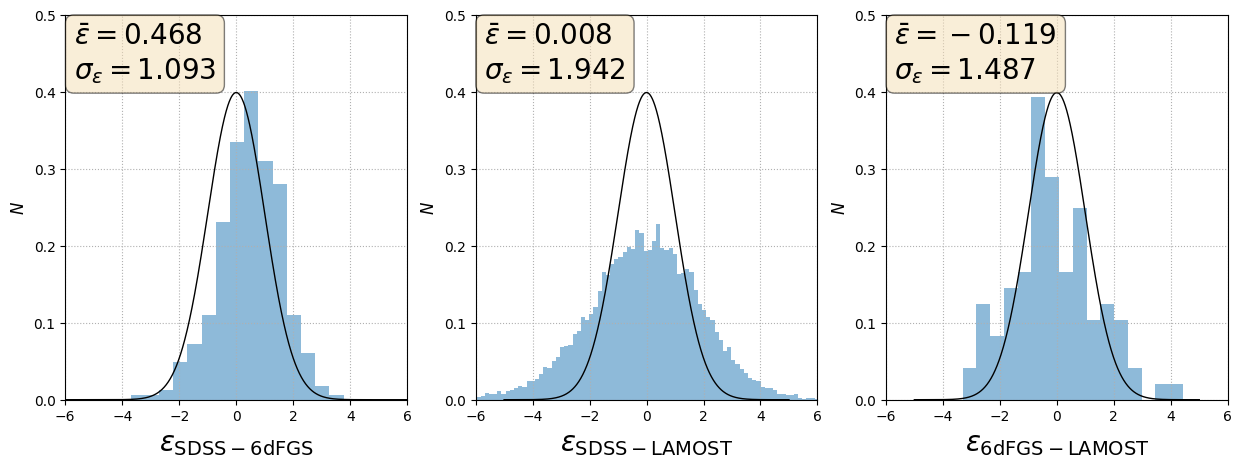

In [10]:
from scipy.stats import norm
from scipy.optimize import curve_fit

# Store the velocity dispersions and errors in a single array
sig = np.array([df['s_sdss'],df['s_6df'],df['s_lamost']])
dsig = np.array([df['es_sdss'],df['es_6df'],df['es_lamost']])

# sigma clipping
sigma_clip = 7.5
# offset clipping
delta_clip = 0.2


#--------------------------------- SDSS vs 6dFGS -------------------------------------------------------#
## The discrepancy between s
delta = sig[0,:]-sig[1,:]
## Exclude erroneous measurements whose discrepancies are greater than delta_clip
cut = np.absolute(delta)<=delta_clip
epsilon = delta[cut]/np.sqrt(dsig[0,:][cut]**2+dsig[1,:][cut]**2)
## Remove nan values
epsilon = epsilon[~np.isnan(epsilon)]
## Apply sigma clipping
epsilon = epsilon[np.absolute(epsilon)<5.]

print('=============================SDSS vs 6dFGS=============================')
print('Mean of epsilon = %.3f' % np.mean(epsilon))
print('Std of epsilon = %.3f' % np.std(epsilon))
print('Comparisons = %.0f' % len(epsilon))
off_sig = np.absolute(np.mean(epsilon))/(np.std(epsilon)/np.sqrt(len(epsilon)))
err_sig = np.absolute(1-np.std(epsilon))/(np.std(epsilon)/np.sqrt(2*len(epsilon)-2))
print('Offset significance = %.2f' % off_sig)
print('Error significance = %.2f' % err_sig)

plt.figure(figsize=(15,5))
plt.subplot(131)

n_bins = 15
plt.hist(epsilon,bins=n_bins,density=True,alpha=0.5)

x_model = np.linspace(-6,6,1000)
y_model = norm.pdf(x_model,0,1)

plt.plot(x_model,y_model,linewidth=1,color='k')
plt.grid(linestyle=':')
# plt.title(r'SDSS vs 6dFGS ($N = $%.0f)' % len(epsilon))
plt.xlabel(r'$\epsilon_\mathrm{SDSS-6dFGS}$',fontsize=20)
# plt.xlim(-4,4)
plt.xlim(-6,6)

# Legend position
xloc = -5.7
yloc = 0.49
fontsize_legend = 20

plt.ylim(0,0.5)
plt.ylabel(r'$N$',fontsize=12)
# plt.text(-3,0.5,r'$\bar{\epsilon} = $ %.2f' % np.mean(epsilon))
textstr = '\n'.join((
    r'$\bar{\epsilon}=%.3f$' % np.mean(epsilon),
    r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(xloc, yloc, textstr, fontsize=fontsize_legend,
        verticalalignment='top', bbox=props)

#--------------------------------- SDSS vs LAMOST -------------------------------------------------------#
delta = sig[0,:]-sig[2,:]
cut = np.absolute(delta)<=delta_clip
epsilon = delta[cut]/np.sqrt(dsig[0,:][cut]**2+dsig[2,:][cut]**2)
epsilon = epsilon[~np.isnan(epsilon)]
epsilon = epsilon[np.absolute(epsilon)<sigma_clip]

print('=============================SDSS vs LAMOST=============================')
print('Mean of epsilon = %.3f' % np.mean(epsilon))
print('Std of epsilon = %.3f' % np.std(epsilon))
print('Comparisons = %.0f' % len(epsilon))
off_sig = np.absolute(np.mean(epsilon))/(np.std(epsilon)/np.sqrt(len(epsilon)))
err_sig = np.absolute(1-np.std(epsilon))/(np.std(epsilon)/np.sqrt(2*len(epsilon)-2))
print('Offset significance = %.2f' % off_sig)
print('Error significance = %.2f' % err_sig)

# plt.figure(figsize=(15,5))
# plt.subplot(131)

plt.subplot(132)

n_bins = 100
plt.hist(epsilon,bins=n_bins,density=True,alpha=0.5)

# fit with Gaussian
def gaus(x,mu,sig):
    return (1/np.sqrt(2*np.pi*sig**2))*np.exp(-0.5*((x-mu)/sig)**2)

y, x_edges = np.histogram(epsilon,bins=n_bins,density=True)
x = (x_edges[1:] + x_edges[:-1])/2
popt, pcov = curve_fit(gaus,x,y,p0=[0,1])
popt[1] = np.absolute(popt[1])

x_model = np.linspace(-5,5,1000)
y_model = norm.pdf(x_model,0,1)

plt.plot(x_model,y_model,linewidth=1,color='k')
plt.grid(linestyle=':')
# plt.title(r'SDSS vs LAMOST ($N = $%.0f)' % len(epsilon))
plt.xlabel(r'$\epsilon_\mathrm{SDSS-LAMOST}$',fontsize=20)
plt.ylabel(r'$N$',fontsize=12)
# plt.xlim(-4,4)
plt.xlim(-6,6)
plt.ylim(0,0.5)

# textstr = '\n'.join((
#     r'$\bar{\epsilon}=%.3f$' % np.mean(epsilon),
#     r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# plt.text(-3.8, 0.44, textstr, fontsize=14,
#         verticalalignment='top', bbox=props)

# Use the fitted Gaussian
textstr = '\n'.join((
    r'$\bar{\epsilon}=%.3f$' % popt[0],
    r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(xloc, yloc, textstr, fontsize=fontsize_legend,
        verticalalignment='top', bbox=props)

#--------------------------------- 6dFGS vs LAMOST -------------------------------------------------------#
epsilon = (sig[1,:]-sig[2,:])/np.sqrt(dsig[1,:]**2+dsig[2,:]**2)
epsilon = epsilon[~np.isnan(epsilon)]
epsilon = epsilon[epsilon<sigma_clip]

print('=============================6dFGS vs LAMOST=============================')
print('Mean of epsilon = %.3f' % np.mean(epsilon))
print('Std of epsilon = %.3f' % np.std(epsilon))
print('Comparisons = %.0f' % len(epsilon))
off_sig = np.absolute(np.mean(epsilon))/(np.std(epsilon)/np.sqrt(len(epsilon)))
err_sig = np.absolute(1-np.std(epsilon))/(np.std(epsilon)/np.sqrt(2*len(epsilon)-2))
print('Offset significance = %.2f' % off_sig)
print('Error significance = %.2f' % err_sig)

plt.subplot(133)

n_bins = 16
plt.hist(epsilon,bins=n_bins,density=True,alpha=0.5)

x_model = np.linspace(-5,5,1000)
y_model = norm.pdf(x_model,0,1)
plt.plot(x_model,y_model,linewidth=1,color='k')
plt.grid(linestyle=':')
# plt.title(r'6dFGS vs LAMOST ($N = $%.0f)' % len(epsilon))
plt.xlabel(r'$\epsilon_\mathrm{6dFGS-LAMOST}$',fontsize=20)
plt.ylabel(r'$N$',fontsize=12)
# plt.xlim(-4,4)
plt.xlim(-6,6)
plt.ylim(0,0.5)

textstr = '\n'.join((
    r'$\bar{\epsilon}=%.3f$' % np.mean(epsilon),
    r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(xloc, yloc, textstr, fontsize=fontsize_legend,
        verticalalignment='top', bbox=props)
# plt.savefig('/home/mrafifrbbn/Documents/Research/images/epsilon_before.png',dpi=400, bbox_inches = 'tight', pad_inches = 0)
plt.show()

=============================SDSS vs 6dFGS=============================
Mean of epsilon = 0.454
Std of epsilon = 1.042
Comparisons = 330
Offset significance = 7.91
Error significance = 1.04
=============================SDSS vs LAMOST=============================
Mean of epsilon = -0.037
Std of epsilon = 1.038
Comparisons = 20407
Offset significance = 5.10
Error significance = 7.32
=============================6dFGS vs LAMOST=============================
Mean of epsilon = -0.139
Std of epsilon = 1.311
Comparisons = 100
Offset significance = 1.06
Error significance = 3.34


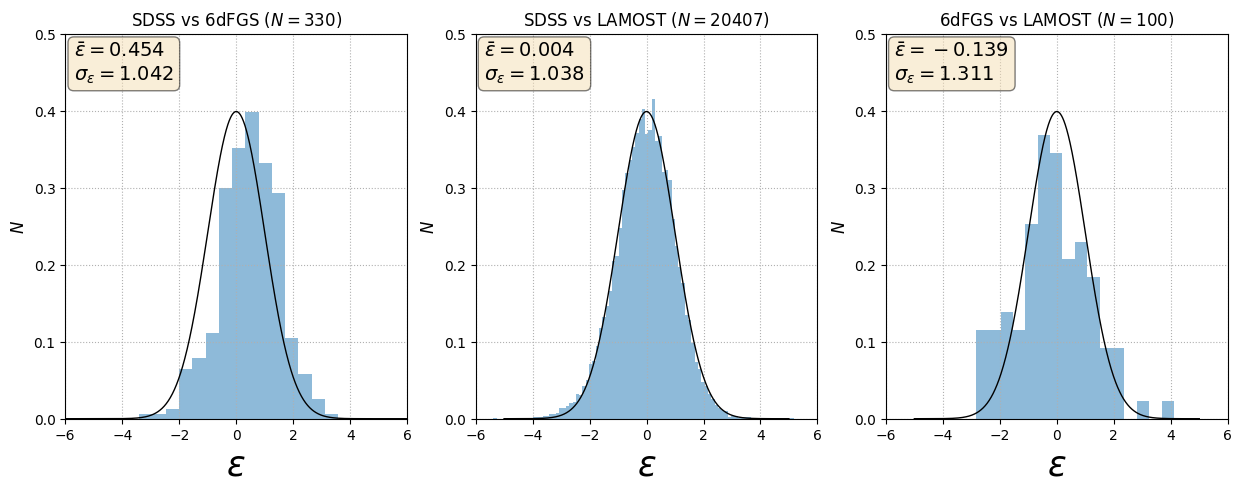

In [11]:
# Read the file

# Define the error scalings
k1 = 1.830
k2 = 1.916

# Store the velocity dispersions and errors in a single array
sig = np.array([df['s_sdss'],df['s_6df'],df['s_lamost']])
dsig = np.array([k1*df['es_sdss'],df['es_6df'],k2*df['es_lamost']])

# plt.rcParams["mathtext.fontset"] = "cm"

# sigma clipping
sigma_clip = 7.5
# offset clipping
delta_clip = 0.2


#--------------------------------- SDSS vs 6dFGS -------------------------------------------------------#
## The discrepancy between s
delta = sig[0,:]-sig[1,:]
## Exclude erroneous measurements whose discrepancies are greater than delta_clip
cut = np.absolute(delta)<=delta_clip
epsilon = delta[cut]/np.sqrt(dsig[0,:][cut]**2+dsig[1,:][cut]**2)
## Remove nan values
epsilon = epsilon[~np.isnan(epsilon)]
## Apply sigma clipping
epsilon = epsilon[np.absolute(epsilon)<5.]

print('=============================SDSS vs 6dFGS=============================')
print('Mean of epsilon = %.3f' % np.mean(epsilon))
print('Std of epsilon = %.3f' % np.std(epsilon))
print('Comparisons = %.0f' % len(epsilon))
off_sig = np.absolute(np.mean(epsilon))/(np.std(epsilon)/np.sqrt(len(epsilon)))
err_sig = np.absolute(1-np.std(epsilon))/(np.std(epsilon)/np.sqrt(2*len(epsilon)-2))
print('Offset significance = %.2f' % off_sig)
print('Error significance = %.2f' % err_sig)

plt.figure(figsize=(15,5))
plt.subplot(131)

n_bins = 15
plt.hist(epsilon,bins=n_bins,density=True,alpha=0.5)

x_model = np.linspace(-6,6,1000)
y_model = norm.pdf(x_model,0,1)

plt.plot(x_model,y_model,linewidth=1,color='k')
plt.grid(linestyle=':')
plt.title(r'SDSS vs 6dFGS ($N = $%.0f)' % len(epsilon))
plt.xlabel(r'$\epsilon$',fontsize=25)
# plt.xlim(-4,4)
plt.xlim(-6,6)

plt.ylim(0,0.5)
plt.ylabel(r'$N$',fontsize=12)
# plt.text(-3,0.5,r'$\bar{\epsilon} = $ %.2f' % np.mean(epsilon))
textstr = '\n'.join((
    r'$\bar{\epsilon}=%.3f$' % np.mean(epsilon),
    r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-5.7, 0.49, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

#--------------------------------- SDSS vs LAMOST -------------------------------------------------------#
delta = sig[0,:]-sig[2,:]
cut = np.absolute(delta)<=delta_clip
epsilon = delta[cut]/np.sqrt(dsig[0,:][cut]**2+dsig[2,:][cut]**2)
epsilon = epsilon[~np.isnan(epsilon)]
epsilon = epsilon[np.absolute(epsilon)<sigma_clip]

print('=============================SDSS vs LAMOST=============================')
print('Mean of epsilon = %.3f' % np.mean(epsilon))
print('Std of epsilon = %.3f' % np.std(epsilon))
print('Comparisons = %.0f' % len(epsilon))
off_sig = np.absolute(np.mean(epsilon))/(np.std(epsilon)/np.sqrt(len(epsilon)))
err_sig = np.absolute(1-np.std(epsilon))/(np.std(epsilon)/np.sqrt(2*len(epsilon)-2))
print('Offset significance = %.2f' % off_sig)
print('Error significance = %.2f' % err_sig)

# plt.figure(figsize=(15,5))
# plt.subplot(131)

plt.subplot(132)

n_bins = 100
plt.hist(epsilon,bins=n_bins,density=True,alpha=0.5)

# fit with Gaussian
def gaus(x,mu,sig):
    return (1/np.sqrt(2*np.pi*sig**2))*np.exp(-0.5*((x-mu)/sig)**2)

y, x_edges = np.histogram(epsilon,bins=n_bins,density=True)
x = (x_edges[1:] + x_edges[:-1])/2
popt, pcov = curve_fit(gaus,x,y,p0=[0,1])
popt[1] = np.absolute(popt[1])

x_model = np.linspace(-5,5,1000)
y_model = norm.pdf(x_model,0,1)

plt.plot(x_model,y_model,linewidth=1,color='k')
plt.grid(linestyle=':')
plt.title(r'SDSS vs LAMOST ($N = $%.0f)' % len(epsilon))
plt.xlabel(r'$\epsilon$',fontsize=25)
plt.ylabel(r'$N$',fontsize=12)
# plt.xlim(-4,4)
plt.xlim(-6,6)
plt.ylim(0,0.5)

# textstr = '\n'.join((
#     r'$\bar{\epsilon}=%.3f$' % np.mean(epsilon),
#     r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# plt.text(-3.8, 0.44, textstr, fontsize=14,
#         verticalalignment='top', bbox=props)

# Use the fitted Gaussian
textstr = '\n'.join((
    r'$\bar{\epsilon}=%.3f$' % popt[0],
    r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-5.7,0.49, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

#--------------------------------- 6dFGS vs LAMOST -------------------------------------------------------#
epsilon = (sig[1,:]-sig[2,:])/np.sqrt(dsig[1,:]**2+dsig[2,:]**2)
epsilon = epsilon[~np.isnan(epsilon)]
epsilon = epsilon[epsilon<sigma_clip]

print('=============================6dFGS vs LAMOST=============================')
print('Mean of epsilon = %.3f' % np.mean(epsilon))
print('Std of epsilon = %.3f' % np.std(epsilon))
print('Comparisons = %.0f' % len(epsilon))
off_sig = np.absolute(np.mean(epsilon))/(np.std(epsilon)/np.sqrt(len(epsilon)))
err_sig = np.absolute(1-np.std(epsilon))/(np.std(epsilon)/np.sqrt(2*len(epsilon)-2))
print('Offset significance = %.2f' % off_sig)
print('Error significance = %.2f' % err_sig)

plt.subplot(133)

n_bins = 16
plt.hist(epsilon,bins=n_bins,density=True,alpha=0.5)

x_model = np.linspace(-5,5,1000)
y_model = norm.pdf(x_model,0,1)
plt.plot(x_model,y_model,linewidth=1,color='k')
plt.grid(linestyle=':')
plt.title(r'6dFGS vs LAMOST ($N = $%.0f)' % len(epsilon))
plt.xlabel(r'$\epsilon$',fontsize=25)
plt.ylabel(r'$N$',fontsize=12)
# plt.xlim(-4,4)
plt.xlim(-6,6)
plt.ylim(0,0.5)

textstr = '\n'.join((
    r'$\bar{\epsilon}=%.3f$' % np.mean(epsilon),
    r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-5.7, 0.49, textstr, fontsize=14,
        verticalalignment='top', bbox=props)
# plt.savefig('../../images/epsilon_after.png',dpi=400, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [ ]:
# Set random seed
np.random.seed(42)

# Offset clipping
cut = 0.2
# Offset significance target is less than this
target = 0.5
# Number of bootstrapping
nboot = 10
N = len(sig[0,:])
# 3 surveys in total
runs = 3

# Return random Gaussian deviates for Monte Carlo purposes
def gauss(ndev):
    deviate = []
    for i in range(ndev):
        deviate.append(np.random.normal())
    return deviate

# Total offset (scaled to whichever survey picked)
totoff = np.empty(runs)
# Average offset for individual survey
off = np.empty(runs)
# The error
err = np.empty(runs)
# Weighted error
norms = np.empty(runs)
# Ratio between offset and error
rat = np.empty(runs)

apply = 0

for boot in range(nboot):
    if (boot == 0):
        ssig = sig
        dsig = dsig
    else:
        ssig = sig + dsig * gauss(N)
        dsig = dsig
    
    iteration = 0
    maxrat = 999
    for run in range(runs):
        totoff[run] = 0
    while ((maxrat >= target) and (iteration < 1)):
        iteration += 1
        print('Simulation %.f' % boot + ' Iteration %.f' %iteration)
        nbig = 0
        for run in range(runs):
            ssig[run,:] = ssig[run,:] - totoff[run]
        maxrat = 0
                
        for run in range(runs):
            off = np.zeros(runs)
            err = np.zeros(runs)
            norms = np.zeros(runs)
            x = np.zeros((runs,N))
            dx = np.zeros((runs,N))
            m = np.zeros((runs,N))
            y = np.zeros((runs,N))
            dy = np.zeros((runs,N))
            n = np.zeros((runs,N))
            
            for j in range(N):
                if ~np.isnan(ssig[run,j]):
                    x[run,j] += ssig[run,j]/dsig[run,j]**2
                    dx[run,j] += 1/dsig[run,j]**2
                    m[run,j] += 1
                
                for k in range(1,3):
                    if ~np.isnan(sig[run,:][j]) and ~np.isnan(sig[run-k,:][j]):
                        y[run,j] += ssig[run-k,j]/dsig[run-k,j]**2
                        dy[run,j] += 1/dsig[run-k,j]**2
                        n[run,j] += 1

            for gin in range(N):
                wt = m[run,gin] * n[run,gin]
                if (wt > 0):
                    x[run,gin] = x[run,gin]/dx[run,gin]
                    dx[run,gin] = np.sqrt(1/dx[run,gin])
                    y[run,gin] = y[run,gin]/dy[run,gin]
                    dy[run,gin] = np.sqrt(1/dy[run,gin])
                    diff = x[run,gin] - y[run,gin]
                    
                    if np.absolute(diff < cut):
                        off[run] += wt*diff
                        err[run] += wt**2 * (dx[run,gin]**2+dy[run,gin]**2)
                        norms[run] += wt
            
            if (norms[run]>0):
                off[run] = off[run]/norms[run]
                err[run] = np.sqrt(err[run])/norms[run]
                rat[run] = off[run]/err[run]
                print('Run = %d'%run+' N = %d'%norms[run]+' Resid = %.3f'%off[run]+' Error = %.3f'%err[run]+' Level = %.3f'%rat[run])
                absrat = np.absolute(rat[run])
                
                if (absrat>maxrat):
                    maxrat = absrat 
                if (absrat>=target):
                    nbig += 1
                level = apply
                if (absrat>=level):
                    totoff[run] += off[run]
                    off[run] = 0
                    rat[run] = 0
    
    for run in range(runs):
        totoff[run] = totoff[run] - totoff[0]     # using sdss as the fiducial run
        
print('\n')
print('SDSS offset = %.3f' % totoff[0] + r' +- %.3f' % err[0])
print('6dFGS offset = %.3f' % totoff[1] + r' +- %.3f' % err[1])
print('LAMOST offset = %.3f' % totoff[2] + r' +- %.3f' % err[2])